In [179]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

tf.set_random_seed(123)
np.random.seed(123)

### Data Preparation

In [8]:
with open('mnist-hw1.pkl', 'rb') as f:
    data = pickle.load(f)

In [17]:
data_trn, data_val = data['train'], data['test']
print(data_trn.shape, data_val.shape)

(60000, 28, 28, 3) (10000, 28, 28, 3)


### Layers

In [204]:
def conv2d(
    layer_in,
    output_dim,
    kernel_shape, # [kernel_height, kernel_width]
    mask_type, # None, "A" or "B", see paper
    scope, 
    strides=[1, 1], # [column_wise_stride, row_wise_stride]
    verbose=False):
    with tf.variable_scope(scope, reuse=False):
        mask_type = mask_type.lower()
        batch_size, height, width, channel = layer_in.get_shape().as_list()
        if verbose:
            print("building within scope", scope, batch_size, height, width, channel)
        kernel_h, kernel_w = kernel_shape
        stride_h, stride_w = strides

        assert kernel_h % 2 == 1 and kernel_w % 2 == 1

        center_h = kernel_h // 2
        center_w = kernel_w // 2

        weights = tf.get_variable("weights", [kernel_h, kernel_w, channel, output_dim],
                                  tf.float32, tf.contrib.layers.xavier_initializer())

        if mask_type is not None:
            mask = np.ones((kernel_h, kernel_w, channel, output_dim), dtype=np.float32)

            mask[center_h, center_w+1:, :, :] = 0.
            mask[center_h+1:, :, :, :] = 0.

            if mask_type == 'a':
                mask[center_h, center_w, :, :] = 0.

            weights.assign(weights * tf.constant(mask, dtype=tf.float32))

        layer_out = tf.nn.conv2d(input=layer_in, filter=weights, strides=[1, stride_h, stride_w, 1], 
                                 padding='SAME', name='layer_in_at_weights')
        biases = tf.get_variable("biases", [output_dim,], tf.float32, tf.zeros_initializer())
        layer_out = tf.nn.bias_add(layer_out, biases, name='layer_in_at_weights_plus_biases')

        layer_out = tf.nn.relu(layer_out, name='layer_out_activated')

    return layer_out

In [205]:
def residual_block(layer_in, hidden_dim, idx):
    assert hidden_dim % 2 == 0
    nn = conv2d(layer_in, output_dim=hidden_dim//2, kernel_shape=[1, 1], mask_type="B", 
                scope="residual_block_0_"+str(idx))
    nn = conv2d(nn, output_dim=hidden_dim//2, kernel_shape=[3, 3], mask_type="B", 
                scope="residual_block_1_"+str(idx))
    nn = conv2d(nn, output_dim=hidden_dim, kernel_shape=[1, 1], mask_type="B", 
                scope="residual_block_2_"+str(idx))
    layer_out = tf.add(layer_in, nn, name="residual_block_out_"+str(idx))
    return layer_out

### Architecture

In [206]:
class PixelCNN():
    def __init__(self, sess, color_dim=4, hidden_dim=16, out_hidden_dim=32, 
                 recurrent_length=12, out_recurrent_length=2, 
                 input_shape=[28, 28, 3], learning_rate=1e-3, grad_clip=1):

        self.sess = sess
        self.height, self.width, self.num_channels = input_shape
        self.input = tf.placeholder(tf.float32, [None] + input_shape, name="input")
        
        '''
        build layers
        '''
        nn = conv2d(self.input, output_dim=hidden_dim, kernel_shape=[7, 7], mask_type="A", 
                    scope="conv_in")
        for idx in range(recurrent_length):
            nn = residual_block(nn, hidden_dim, idx)

        for idx in range(out_recurrent_length):
            nn = conv2d(nn, output_dim=out_hidden_dim, kernel_shape=[1, 1], mask_type="B", 
                        scope="conv_out"+str(idx))
            nn = tf.nn.relu(nn, name='conv_out_activated_'+str(idx))
            
        self.logits = conv2d(nn, output_dim=self.num_channels*color_dim, kernel_shape=[1, 1], mask_type="B", 
                             scope="conv_logits")

        '''
        compute loss
        
        labels = self.input = [None, 28, 28, 3] -> [None, 28, 28, 3, 4] (one-hot encoded)
        logits = self.logits = [None, 28, 28, 3*4] -> [None, 28, 28, 3, 4] (reshaped)
        '''
        self.logits = tf.reshape(self.logits, [-1, self.height, self.width, self.num_channels, color_dim], 
                                 name="logits_reshaped")
        self.probs = tf.nn.softmax(self.logits, axis=-1, name="probs")
        self.prediction = tf.argmax(self.probs, axis=-1, name="prediction")
        self.input_one_hot = tf.one_hot(tf.cast(self.input, tf.int32), color_dim, axis=-1, 
                                        name='input_one_hot')
        self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                   logits=self.logits, labels=self.input_one_hot, name='loss'))

        optimizer = tf.train.RMSPropOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(self.loss)
        new_grads_and_vars = \
            [(tf.clip_by_value(gv[0], -grad_clip, grad_clip), gv[1]) for gv in grads_and_vars]
        self.op = optimizer.apply_gradients(new_grads_and_vars)
        
    def step(self, batch, with_update=False):
        if with_update:
            _, loss = self.sess.run([self.op, self.loss], feed_dict={self.input: batch})
        else:
            loss = self.sess.run(self.loss, feed_dict={self.input: batch})
        return loss
    
    def generate(self, num_samples):
        samples = np.zeros((num_samples, self.height, self.width, self.num_channels), dtype='float32')
        for i in range(self.height):
            for j in range(self.width):
                for k in range(self.num_channels):
                    samples[:, i, j, k] = self.sess.run(self.prediction, feed_dict={self.input: samples})[:, i, j, k]
        return samples

In [207]:
def train(sess, data_trn, data_val, batch_size=128, num_epochs=3, log_per_epoch=1):
    network = PixelCNN(sess)
    init_op = tf.initializers.global_variables()
    sess.run(init_op)

    loss_trn = []
    loss_val = []

    for epoch in range(num_epochs):
        loss_trn_batch = []
        for batch in np.array_split(data_trn, np.ceil(len(data_trn)/batch_size)):
            loss = network.step(batch, with_update=True)
            loss_trn_batch.append(loss)

        if epoch % log_per_epoch == 0:
            loss_trn.append(np.mean(loss_trn_batch))
            loss_val.append(network.step(data_val, with_update=False))
            print("at epoch", epoch, loss_trn[-1], loss_val[-1])
    return loss_trn, loss_val, network

### Training

In [208]:
small_data_trn = data_trn[:600]
small_data_val = data_val[:100]

In [209]:
tf.reset_default_graph()
sess = tf.Session()
loss_trn, loss_val, network = train(sess, small_data_trn, small_data_val)

at epoch 0 0.98927367 0.9480351
at epoch 1 0.9214142 0.8871842
at epoch 2 0.8654665 0.8372592


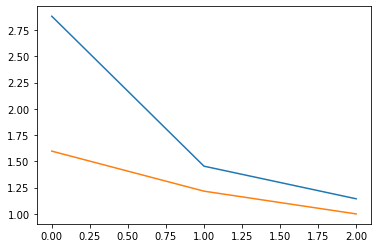

In [200]:
epochs = range(len(loss_trn))
plt.plot(epochs, loss_trn)
plt.plot(epochs, loss_val)

In [202]:
samples = network.generate(2)

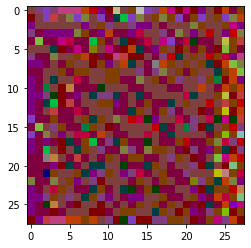

In [203]:
plt.imshow(samples[0]/4, interpolation='nearest')
plt.show()

In [ ]:
sess.close()